In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import numpy as np
import random

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Matplotlib is building the font cache using fc-list. This may take a moment.


Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Define ResNet-18 model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# Instantiate ResNet-18 and move to GPU
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


model = ResNet18().to(device)

In [3]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Helper function to evaluate objectives
def evaluate(individual):
    # Reshape individual into [10, 512] weight matrix
    weights = torch.tensor(individual, dtype=torch.float32).view(10, 512).to(device)
    model.linear.weight.data = weights

    # Rest of the function remains the same
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)

    val_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    # Objective 2: Gaussian regularizer (sum of squared weights)
    gaussian_regularizer = torch.sum(weights ** 2).item()

    # Return objectives
    return val_loss, gaussian_regularizer


# DEAP setup for NSGA-II
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # Minimize both objectives
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)  # Random weights
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=512 * 10)  # Correct size
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", evaluate)

# Initialize population
population = toolbox.population(n=30)
num_generations = 15

# NSGA-II Optimization
for gen in range(num_generations):
    print(f"Generation {gen}")
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.3)

    # Evaluate fitness for offspring
    fitnesses = map(toolbox.evaluate, offspring)
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = fit

    # Select next generation
    population = toolbox.select(offspring, len(population))


Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14


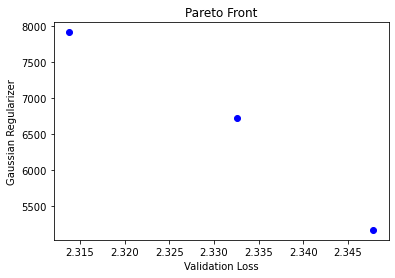

In [4]:
# Extract Pareto front
pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]

# Visualize Pareto front
objectives = np.array([ind.fitness.values for ind in pareto_front])
plt.scatter(objectives[:, 0], objectives[:, 1], c="b")
plt.xlabel("Validation Loss")
plt.ylabel("Gaussian Regularizer")
plt.title("Pareto Front")
plt.show()


In [14]:
weights = torch.tensor(pareto_front[1], dtype=torch.float32).view(10, 512).to(device)
model.linear.weight.data = weights

In [15]:
torch.save(model.state_dict(), 'ResNet18_BiObj.pkl')